In [1]:
"""
    xgboost params-tuning fitting saving forcasting
    xgboost(default) https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
    sklearn(Metrics) https://scikit-learn.org/stable/modules/model_evaluation.html
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, roc_curve, recall_score
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']


In [19]:
#import torch
 
#temp=torch.Tensor([3.])
 
#temp.cuda()

In [20]:
# 数据集
#dataset = pd.read_csv('..\scripts\XGBoost示例\Oil_well_parameters_train.csv', engine='python')
# 划分训练集和验证集
#X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.2,
#random_state=42)


In [8]:
# load datasets
dataset_pv = pd.read_csv('../data/XGBoost_toy_case/merged_pv_new.csv', index_col=[0], parse_dates=[0])
dataset_bld = pd.read_csv('../data/XGBoost_toy_case/merged_bld_new.csv', index_col=[0], parse_dates=[0])

section_date='01-Jan-2020' # to isolate the data for training and future implementation
dataset_bld=dataset_bld.loc[dataset_bld.index < section_date].copy()
dataset_pv=dataset_pv.loc[dataset_pv.index < section_date].copy()

# helper function for spliting the dataset into required format
def section_and_get_x_y(df,split_date,key):
    train = df.loc[df.index < split_date].copy()
    test = df.loc[df.index >= split_date].copy()
    train_x=train.drop(columns=[key])
    train_y=train[key]
    test_x=test.drop(columns=[key])
    test_y=test[key]
    return train_x,train_y,test_x,test_y

X_train,y_train,X_test, y_test = section_and_get_x_y(dataset_bld,'01-Jan-2019','RealPower')


In [11]:
X_test

,RealPower_-1q,RealPower_-2q,RealPower_-3q,RealPower_-4q,RealPower_-5q,RealPower_-6q,RealPower_-7q,RealPower_-8q,RealPower_-9q,RealPower_-10q,...,rain_3h_-3h,snow_1h_-1h,snow_1h_-2h,snow_1h_-3h,snow_3h_-1h,snow_3h_-2h,snow_3h_-3h,clouds_all_-1h,clouds_all_-2h,clouds_all_-3h
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,185.324,184.502,182.847,177.803,178.911,179.297,179.951,179.545,179.678,179.398,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,75.0,90.0,90.0
2019-01-01 00:15:00,183.997,185.324,184.502,182.847,177.803,178.911,179.297,179.951,179.545,179.678,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,75.0,90.0,90.0
2019-01-01 00:30:00,179.844,183.997,185.324,184.502,182.847,177.803,178.911,179.297,179.951,179.545,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,75.0,90.0,90.0
2019-01-01 00:45:00,176.795,179.844,183.997,185.324,184.502,182.847,177.803,178.911,179.297,179.951,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,75.0,90.0,90.0
2019-01-01 01:00:00,174.439,176.795,179.844,183.997,185.324,184.502,182.847,177.803,178.911,179.297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,75.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:45:00,162.594,162.692,164.823,164.036,163.890,164.490,163.107,162.289,162.096,163.077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,40.0,75.0
2019-12-31 23:00:00,163.616,162.594,162.692,164.823,164.036,163.890,164.490,163.107,162.289,162.096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,40.0,40.0
2019-12-31 23:15:00,163.864,163.616,162.594,162.692,164.823,164.036,163.890,164.490,163.107,162.289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,40.0,40.0


In [23]:
def xgboost_parameters():
    """模型调参过程"""
    # 第二步：min_child_weight 以及 max_depth
    # 参数的最佳取值：{'max_depth': 2, 'min_child_weight': 1}
    # 最佳模型得分:0.9180952380952381，模型分数未提高
    params = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_child_weight': [1,2,3,4,5,6]}
	
	# 其他参数设置，每次调参将确定的参数加入，不写即默认参数
    fine_params = {'n_estimators': 50,'tree_method':'gpu_hist'}
    return params, fine_params


In [29]:
def model_adjust_parameters(cv_params, other_params):
    """Params tuning"""
    # basic params
    model = XGBRegressor(**other_params)
    # tuning tool, heuristic searching, k-fold cross-validation, k=12
    # critireon is set as 'mean_absolute_percentage_error'
    optimized_param = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_absolute_percentage_error', cv=6, verbose=2)
    # fit the model
    optimized_param.fit(X_train, y_train)
    # average k-fold cross-validation 
    means = optimized_param.cv_results_['mean_test_score']
    params = optimized_param.cv_results_['params']
    for mean, param in zip(means, params):
        print("mean_score: %f,  params: %r" % (mean, param))
    # Best params 
    print('Best params set:{0}'.format(optimized_param.best_params_))
    # Best score
    print('Score of best model:{0}'.format(optimized_param.best_score_))

    # plot the tuning process
    parameters_score = pd.DataFrame(params, means)
    parameters_score['means_score'] = parameters_score.index
    parameters_score = parameters_score.reset_index(drop=True)
    parameters_score.to_excel('parameters_score.xlsx', index=False)
    # plot the figure showing the score
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.plot(parameters_score.iloc[:, :-1], 'o-')
    plt.legend(parameters_score.columns.to_list()[:-1], loc='upper left')
    plt.title('Parameters_size', loc='left', fontsize='xx-large', fontweight='heavy')
    plt.subplot(2, 1, 2)
    plt.plot(parameters_score.iloc[:, -1], 'r+-')
    plt.legend(parameters_score.columns.to_list()[-1:], loc='upper left')
    plt.title('Score', loc='left', fontsize='xx-large', fontweight='heavy')
    plt.show()


In [25]:
params_dic={
    'n_estimators':[10,20,30,40,50],
    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    'min_child_weight': [1,2,3,4,5,6],
    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'gamma':[0,0.1,0.2,0.3],
    'lambda':[0.5,1,2,3,4,5],
    'alpha':[0,1,2,3,4,5]    
}

Fitting 12 folds for each of 9 candidates, totalling 108 fits
[CV] END ....................................n_estimators=10; total time=   2.5s
[CV] END ....................................n_estimators=10; total time=   1.6s
[CV] END ....................................n_estimators=10; total time=   1.5s
[CV] END ....................................n_estimators=10; total time=   1.6s
[CV] END ....................................n_estimators=10; total time=   1.5s
[CV] END ....................................n_estimators=10; total time=   1.8s
[CV] END ....................................n_estimators=10; total time=   1.5s
[CV] END ....................................n_estimators=10; total time=   1.8s
[CV] END ....................................n_estimators=10; total time=   1.7s
[CV] END ....................................n_estimators=10; total time=   1.7s
[CV] END ....................................n_estimators=10; total time=   1.7s
[CV] END ....................................n_

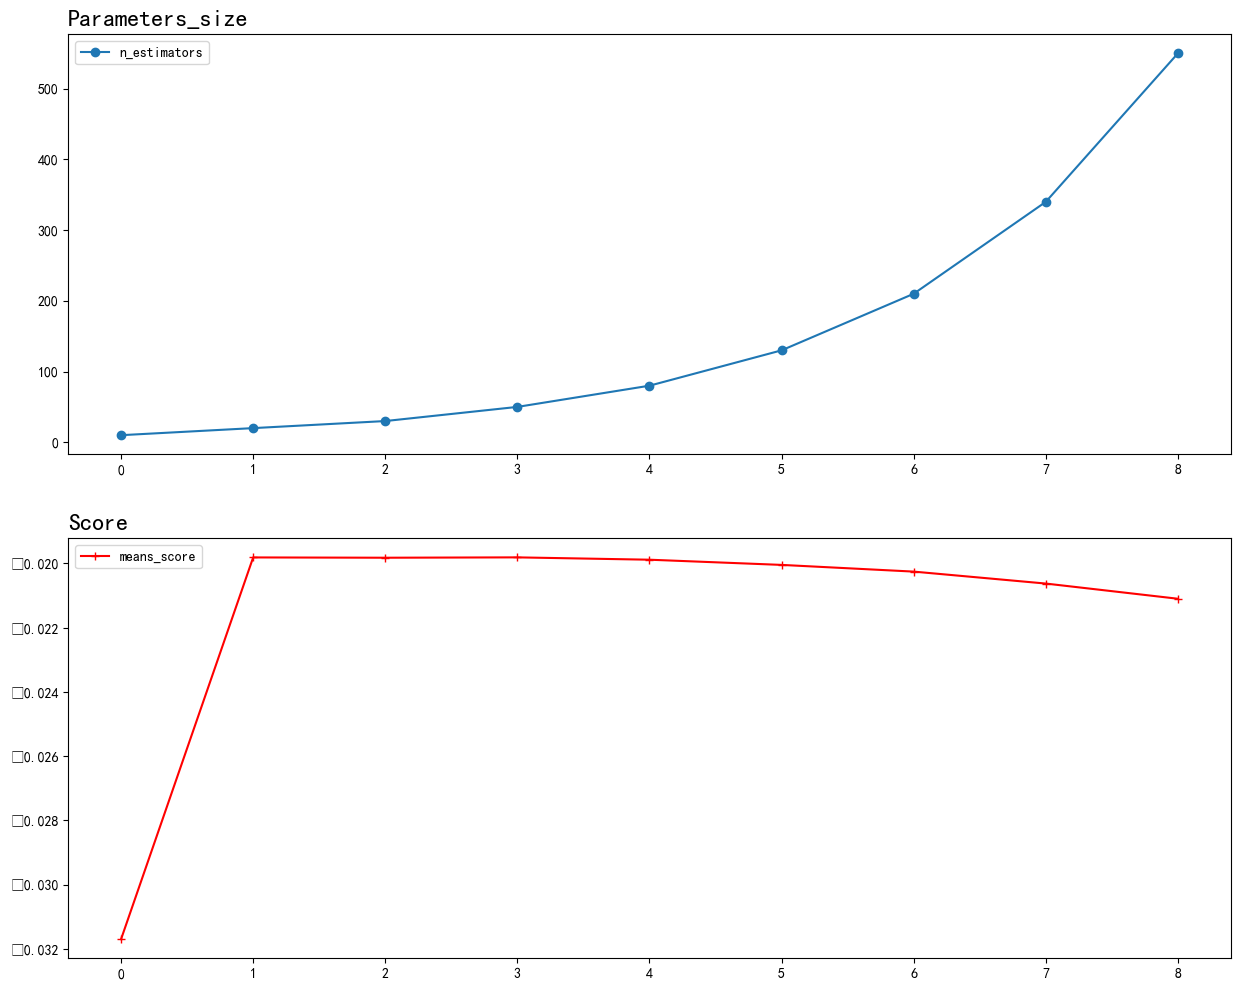

In [27]:
# s1 tuning the n_estimators
params_dic_s1={
    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [1,2,3,4,5,6],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.1,0.2,0.3],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s1
fixed_params = {'tree_method':'gpu_hist'}
model_adjust_parameters(adj_params, fixed_params)


Fitting 12 folds for each of 10 candidates, totalling 120 fits
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.6s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.4s
[CV] END ........................................max_depth=1; total time=   1.2s
[CV] END .....................................

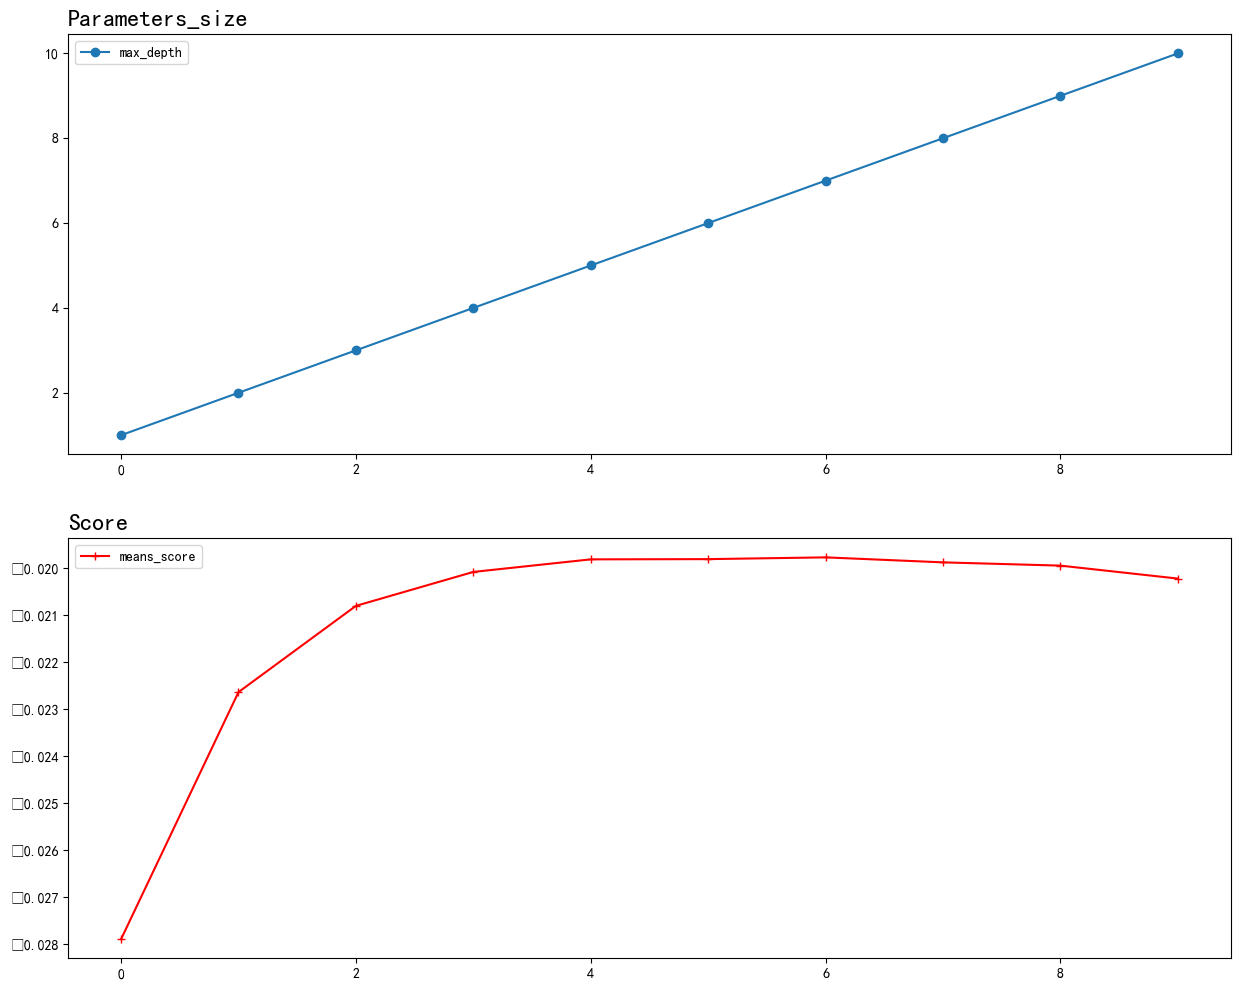

In [28]:
# s2 tuning the max_depth
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [1,2,3,4,5,6,7,8,9,10],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.1,0.2,0.3],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist'}
model_adjust_parameters(adj_params, fixed_params)


Fitting 6 folds for each of 130 candidates, totalling 780 fits
[CV] END ..................max_depth=1, min_child_weight=0.1; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.1; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.1; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.1; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.1; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.1; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.2; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.2; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.2; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.2; total time=   1.4s
[CV] END ..................max_depth=1, min_child_weight=0.2; total time=   1.4s
[CV] END ..................max_depth=1, min_ch

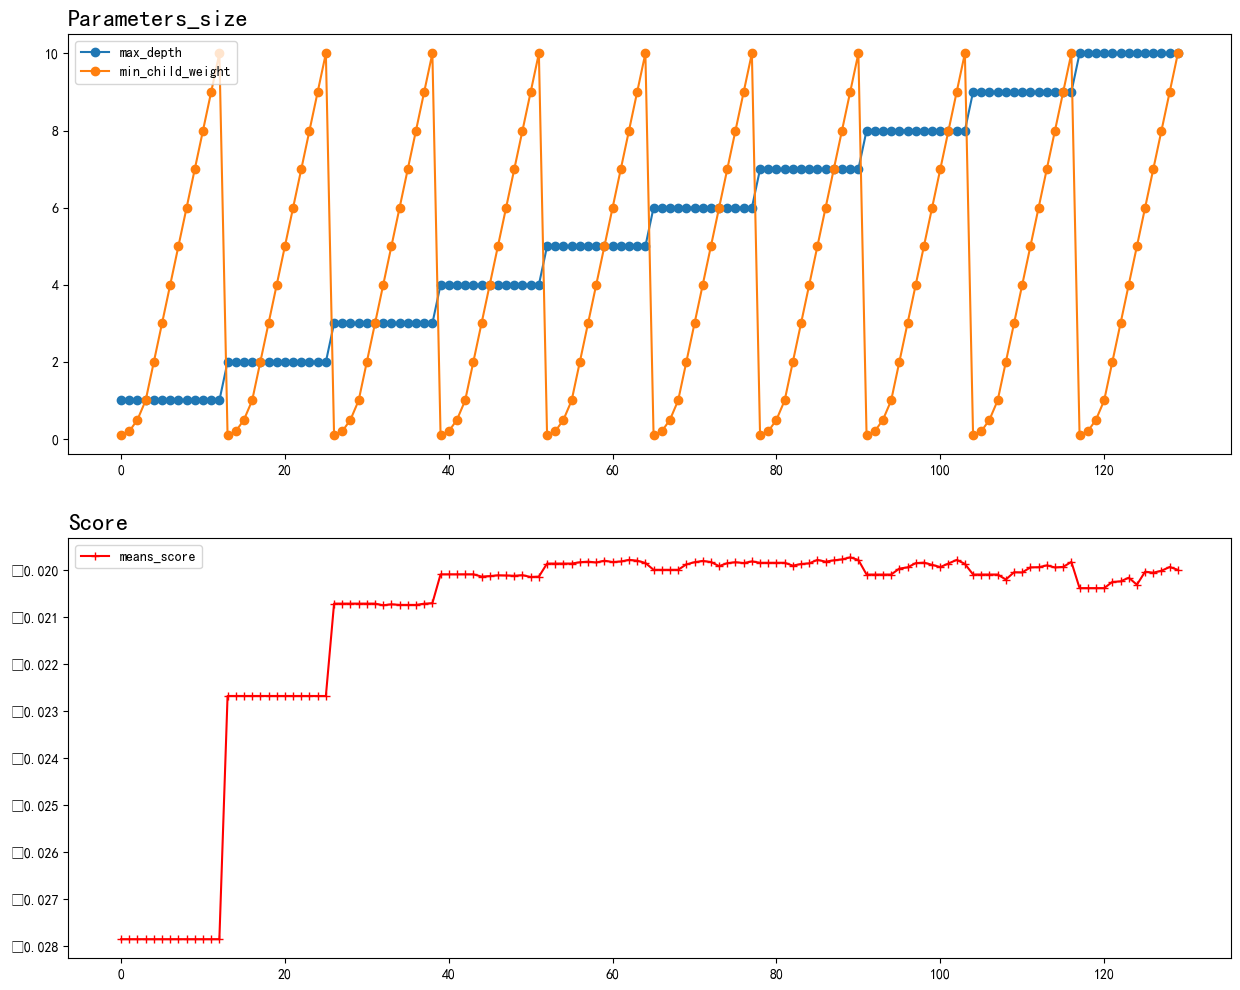

In [30]:
# s2-2 tuning the max_depth with min_child_weight
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    'min_child_weight': [0.1,0.2,0.5,1,2,3,4,5,6,7,8,9,10],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.1,0.2,0.3],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist'}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 5 candidates, totalling 30 fits
[CV] END ................................min_child_weight=10; total time=   6.6s
[CV] END ................................min_child_weight=10; total time=   6.9s
[CV] END ................................min_child_weight=10; total time=   7.0s
[CV] END ................................min_child_weight=10; total time=   6.9s
[CV] END ................................min_child_weight=10; total time=   6.7s
[CV] END ................................min_child_weight=10; total time=   7.0s
[CV] END ................................min_child_weight=20; total time=   6.5s
[CV] END ................................min_child_weight=20; total time=   6.7s
[CV] END ................................min_child_weight=20; total time=   6.9s
[CV] END ................................min_child_weight=20; total time=   6.6s
[CV] END ................................min_child_weight=20; total time=   6.6s
[CV] END ................................min_chil

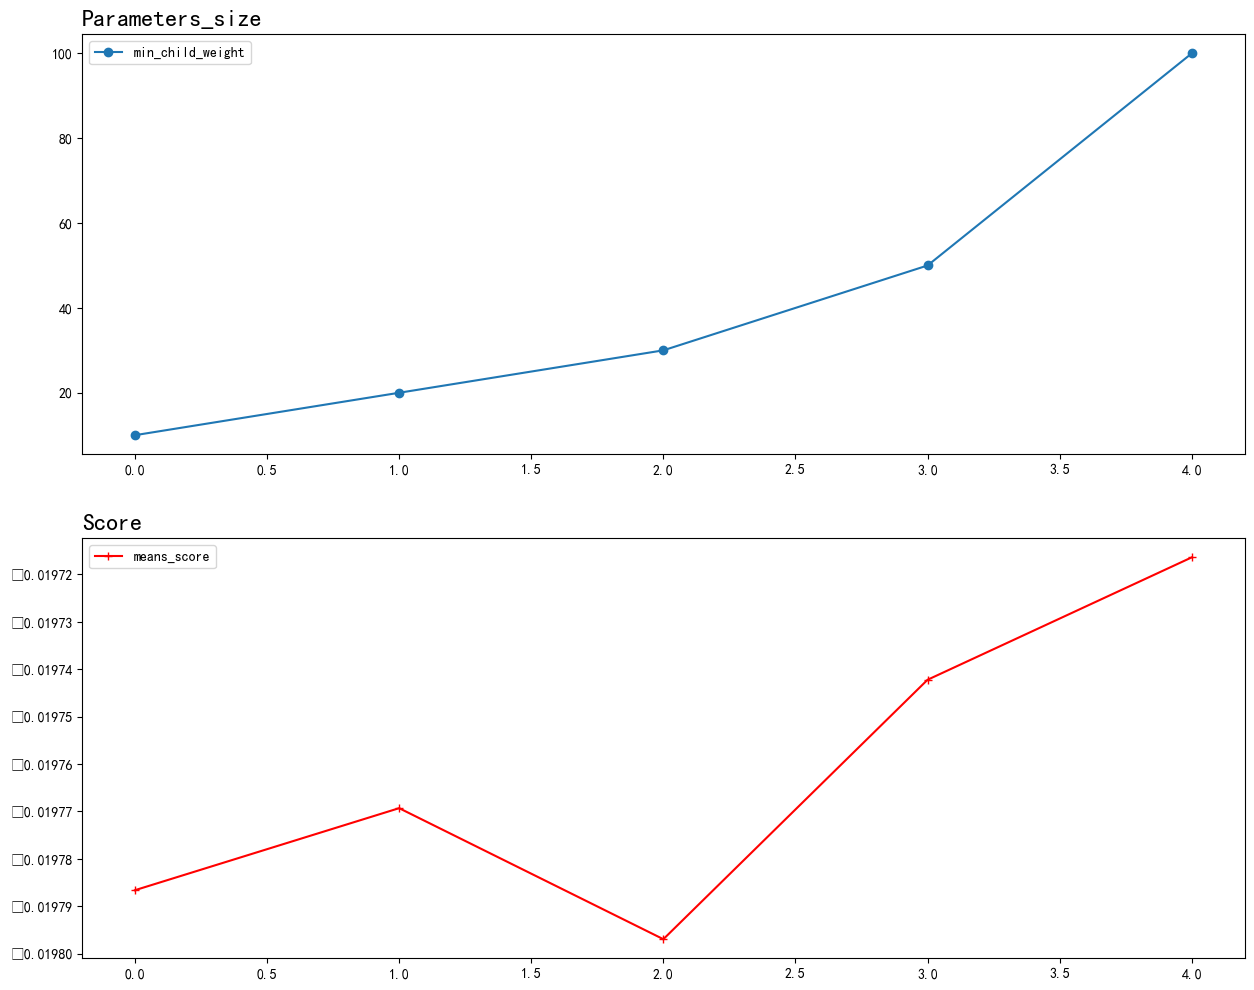

In [31]:
# s2-3 tuning the min_child_weight
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    'min_child_weight': [10,20,30,50,100],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.1,0.2,0.3],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist','max_depth':7}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 7 candidates, totalling 42 fits
[CV] END ...............................min_child_weight=100; total time=   6.0s
[CV] END ...............................min_child_weight=100; total time=   5.8s
[CV] END ...............................min_child_weight=100; total time=   5.7s
[CV] END ...............................min_child_weight=100; total time=   5.9s
[CV] END ...............................min_child_weight=100; total time=   5.8s
[CV] END ...............................min_child_weight=100; total time=   5.9s
[CV] END ...............................min_child_weight=200; total time=   5.3s
[CV] END ...............................min_child_weight=200; total time=   5.2s
[CV] END ...............................min_child_weight=200; total time=   5.2s
[CV] END ...............................min_child_weight=200; total time=   5.5s
[CV] END ...............................min_child_weight=200; total time=   5.3s
[CV] END ...............................min_child

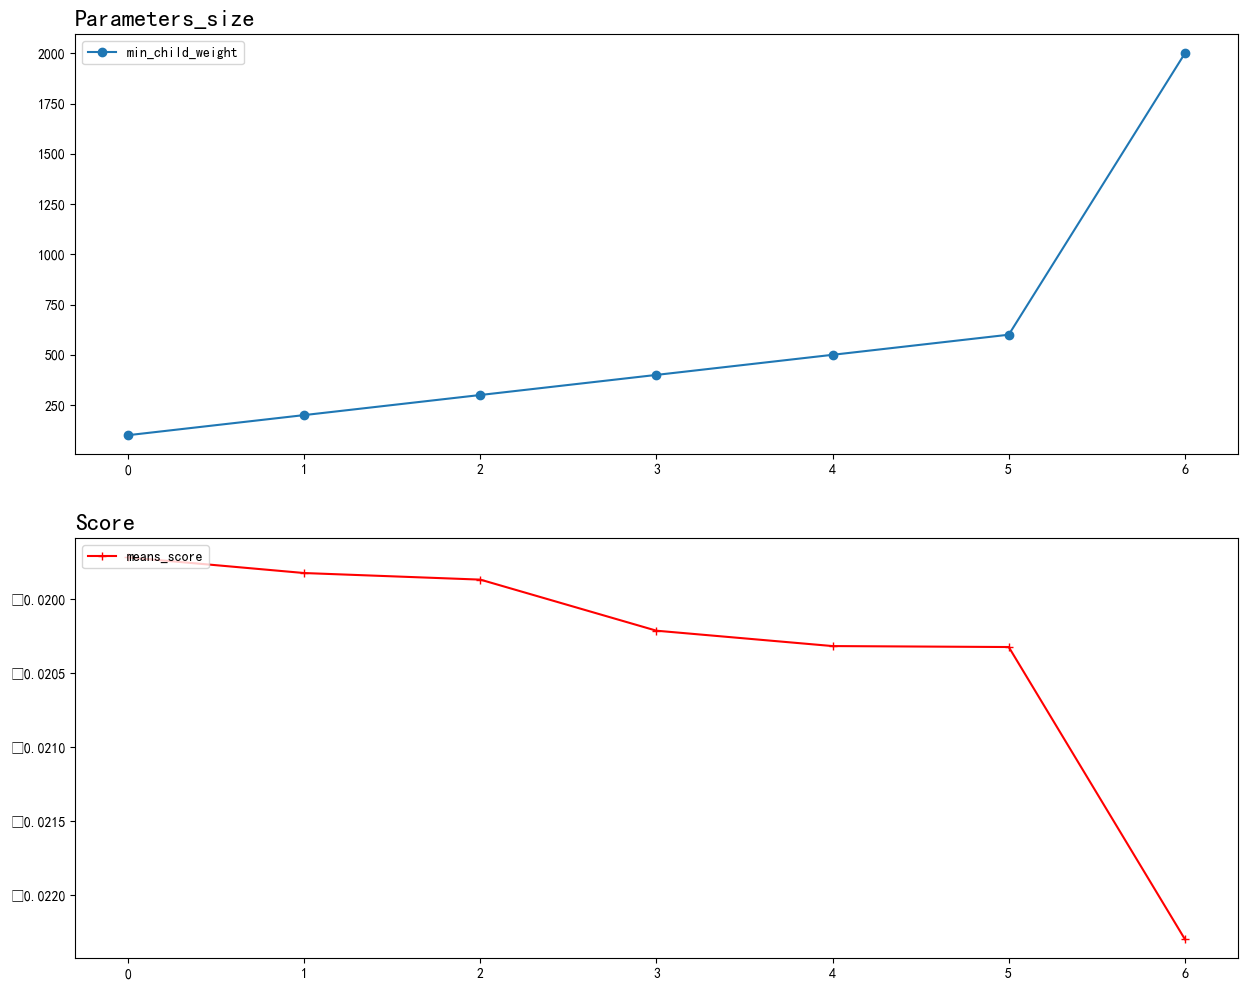

In [32]:
# s2-4 tuning the min_child_weight
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    'min_child_weight': [100,200,300,400,500,600,2000],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.1,0.2,0.3],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist','max_depth':7}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 7 candidates, totalling 42 fits
[CV] END ................................min_child_weight=60; total time=   6.7s
[CV] END ................................min_child_weight=60; total time=   6.8s
[CV] END ................................min_child_weight=60; total time=   6.5s
[CV] END ................................min_child_weight=60; total time=   6.7s
[CV] END ................................min_child_weight=60; total time=   6.6s
[CV] END ................................min_child_weight=60; total time=   6.9s
[CV] END ................................min_child_weight=70; total time=   6.5s
[CV] END ................................min_child_weight=70; total time=   6.4s
[CV] END ................................min_child_weight=70; total time=   6.1s
[CV] END ................................min_child_weight=70; total time=   7.1s
[CV] END ................................min_child_weight=70; total time=   6.3s
[CV] END ................................min_chil

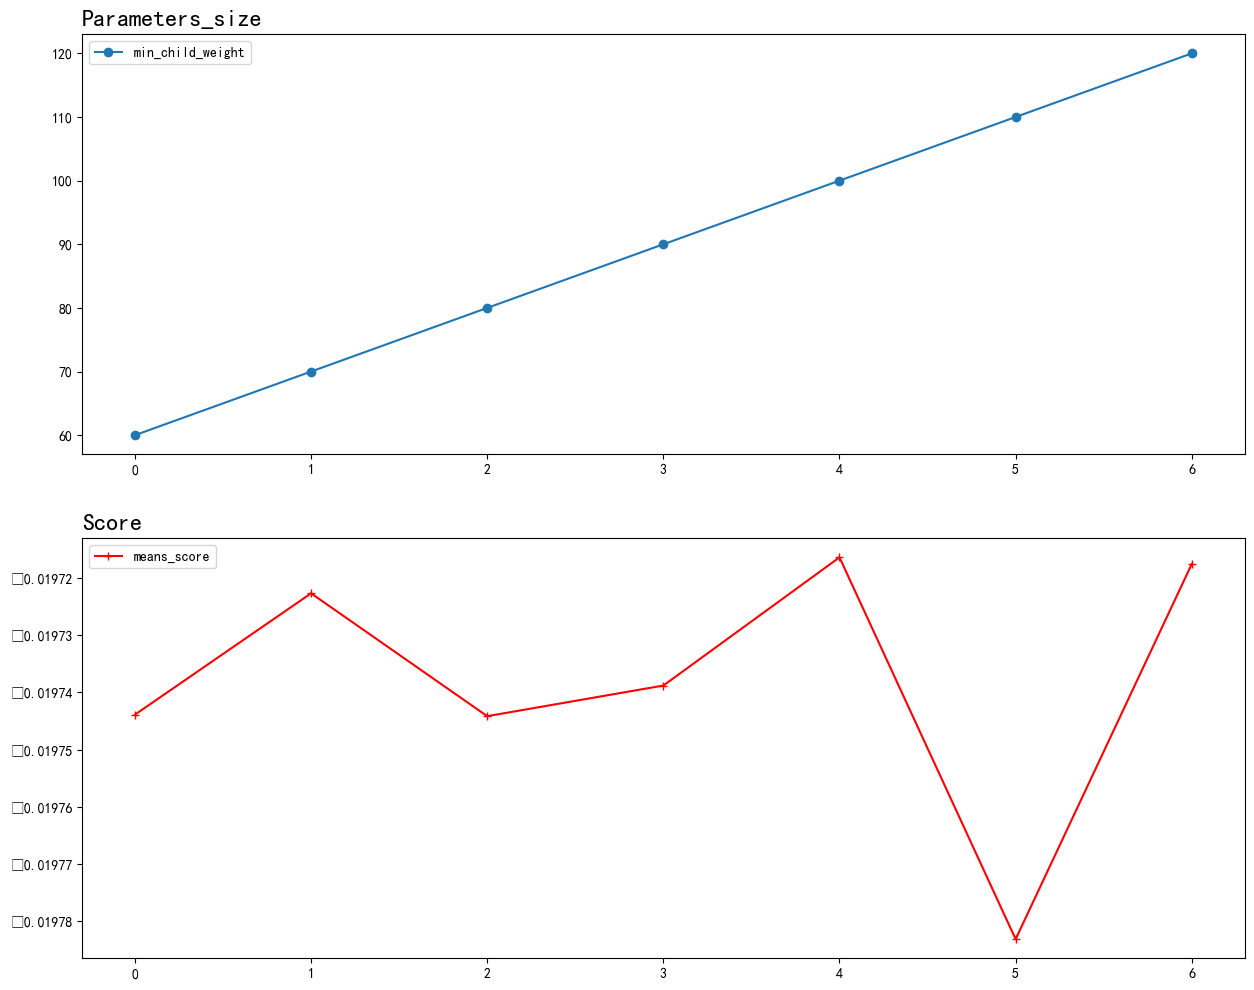

In [33]:
# s2-5 tuning the min_child_weight
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    'min_child_weight': [60,70,80,90,100,110,120],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.1,0.2,0.3],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist','max_depth':7}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 7 candidates, totalling 42 fits
[CV] END .........................................gamma=0.05; total time=   6.3s
[CV] END .........................................gamma=0.05; total time=   5.8s
[CV] END .........................................gamma=0.05; total time=   5.7s
[CV] END .........................................gamma=0.05; total time=   5.9s
[CV] END .........................................gamma=0.05; total time=   5.8s
[CV] END .........................................gamma=0.05; total time=   5.9s
[CV] END ..........................................gamma=0.1; total time=   5.7s
[CV] END ..........................................gamma=0.1; total time=   5.9s
[CV] END ..........................................gamma=0.1; total time=   5.9s
[CV] END ..........................................gamma=0.1; total time=   5.7s
[CV] END ..........................................gamma=0.1; total time=   5.7s
[CV] END ........................................

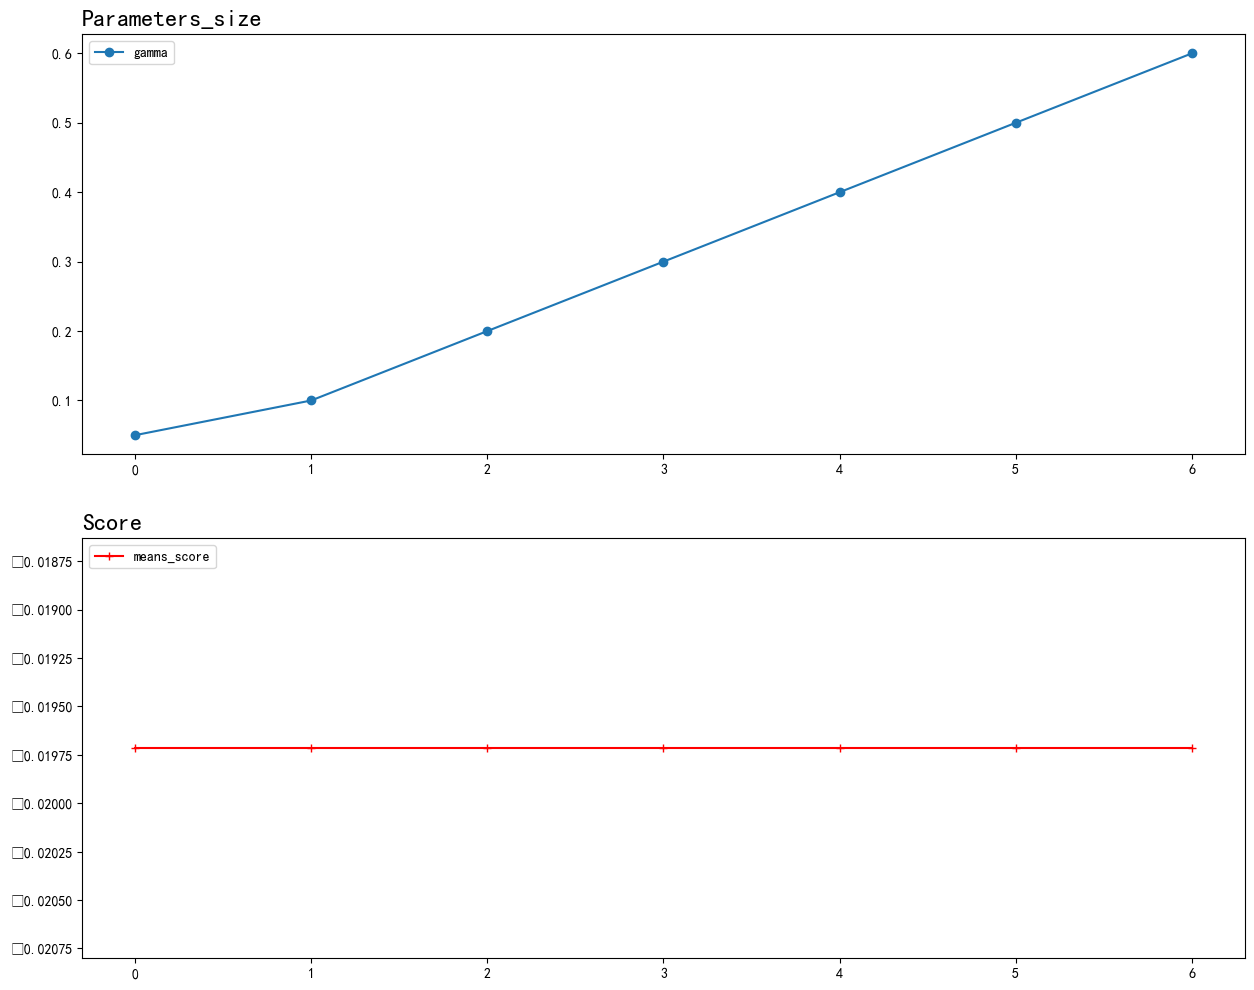

In [34]:
# s3 tuning gamma
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [60,70,80,90,100,110,120],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'gamma':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 5 candidates, totalling 30 fits
[CV] END .........................................gamma=0.01; total time=   5.7s
[CV] END .........................................gamma=0.01; total time=   5.8s
[CV] END .........................................gamma=0.01; total time=   5.8s
[CV] END .........................................gamma=0.01; total time=   5.9s
[CV] END .........................................gamma=0.01; total time=   5.8s
[CV] END .........................................gamma=0.01; total time=   5.8s
[CV] END .........................................gamma=0.02; total time=   5.7s
[CV] END .........................................gamma=0.02; total time=   5.6s
[CV] END .........................................gamma=0.02; total time=   5.7s
[CV] END .........................................gamma=0.02; total time=   5.9s
[CV] END .........................................gamma=0.02; total time=   5.9s
[CV] END ........................................

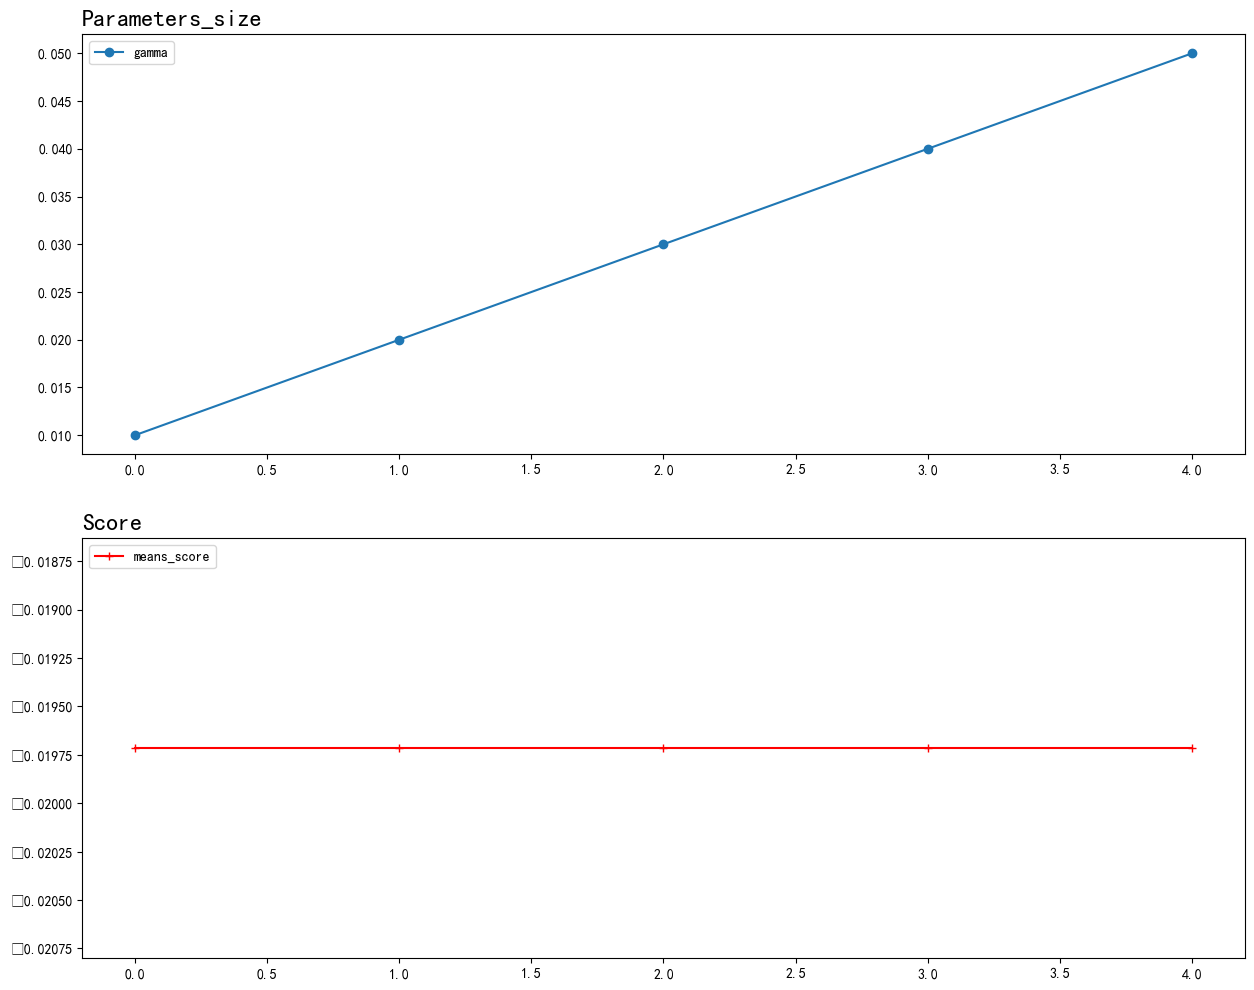

In [35]:
# s3-2 tuning gamma
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [60,70,80,90,100,110,120],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'gamma':[0.01,0.02,0.03,0.04,0.05],
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 5 candidates, totalling 30 fits
[CV] END ............................................gamma=0; total time=   5.7s
[CV] END ............................................gamma=0; total time=   5.8s
[CV] END ............................................gamma=0; total time=   5.7s
[CV] END ............................................gamma=0; total time=   5.9s
[CV] END ............................................gamma=0; total time=   5.7s
[CV] END ............................................gamma=0; total time=   6.0s
[CV] END ........................................gamma=1e-05; total time=   5.7s
[CV] END ........................................gamma=1e-05; total time=   5.9s
[CV] END ........................................gamma=1e-05; total time=   5.8s
[CV] END ........................................gamma=1e-05; total time=   5.9s
[CV] END ........................................gamma=1e-05; total time=   5.8s
[CV] END ........................................

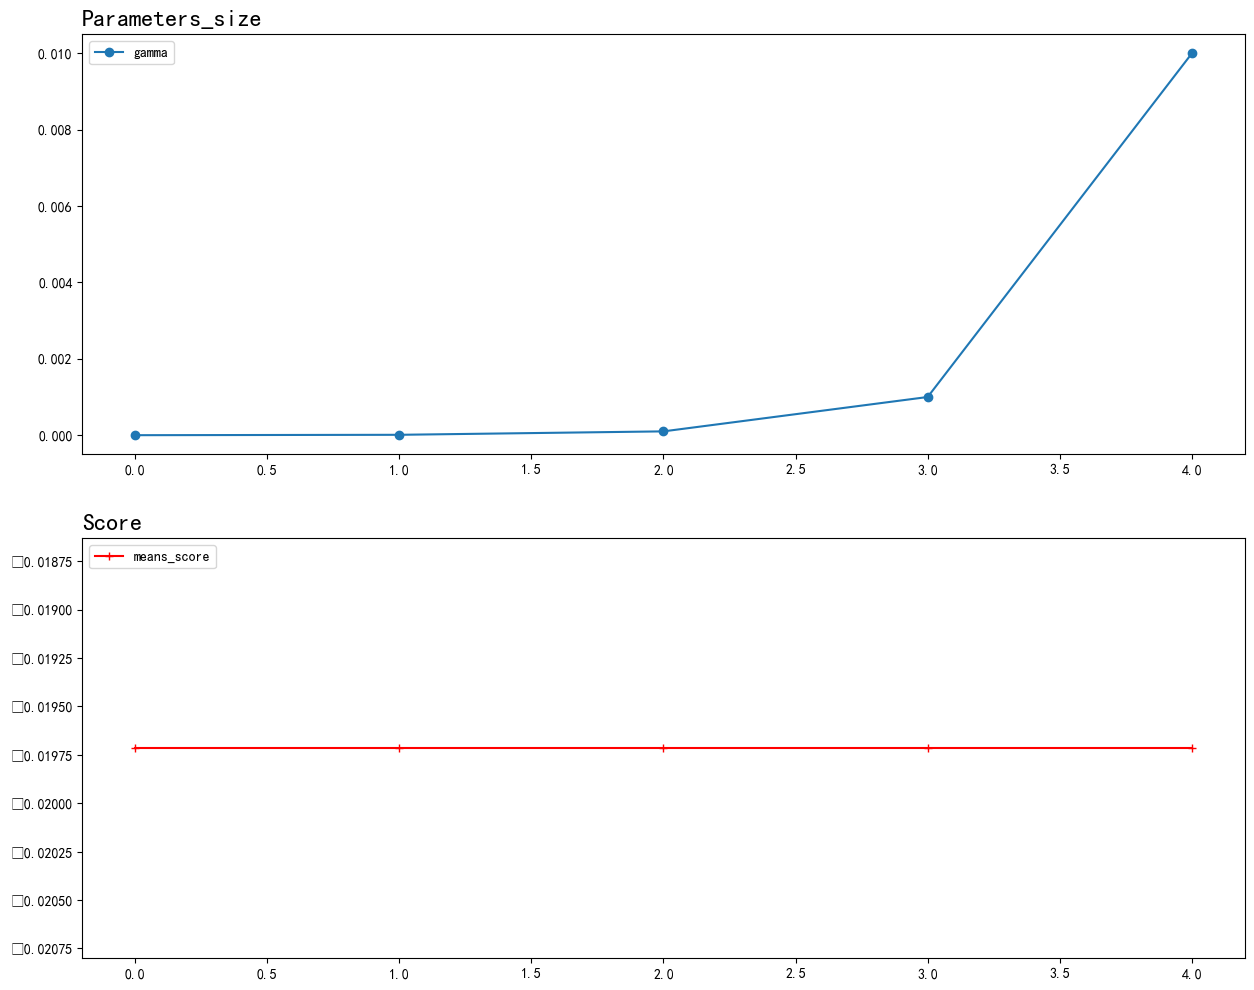

In [37]:
# s3-2 tuning gamma
params_dic_s2={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [60,70,80,90,100,110,120],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'gamma':[0,0.00001,0.0001,0.001,0.01],
#    'subsample': [0.6, 0.7, 0.8, 0.9, 1], 
#    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s2
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   3.0s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   2.8s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   2.8s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   2.8s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   2.9s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   2.9s
[CV] END ................colsample_bytree=0.1, subsample=0.2; total time=   3.1s
[CV] END ................colsample_bytree=0.1, subsample=0.2; total time=   3.2s
[CV] END ................colsample_bytree=0.1, subsample=0.2; total time=   3.2s
[CV] END ................colsample_bytree=0.1, subsample=0.2; total time=   3.1s
[CV] END ................colsample_bytree=0.1, subsample=0.2; total time=   3.0s
[CV] END ................colsample_bytree=0.1,

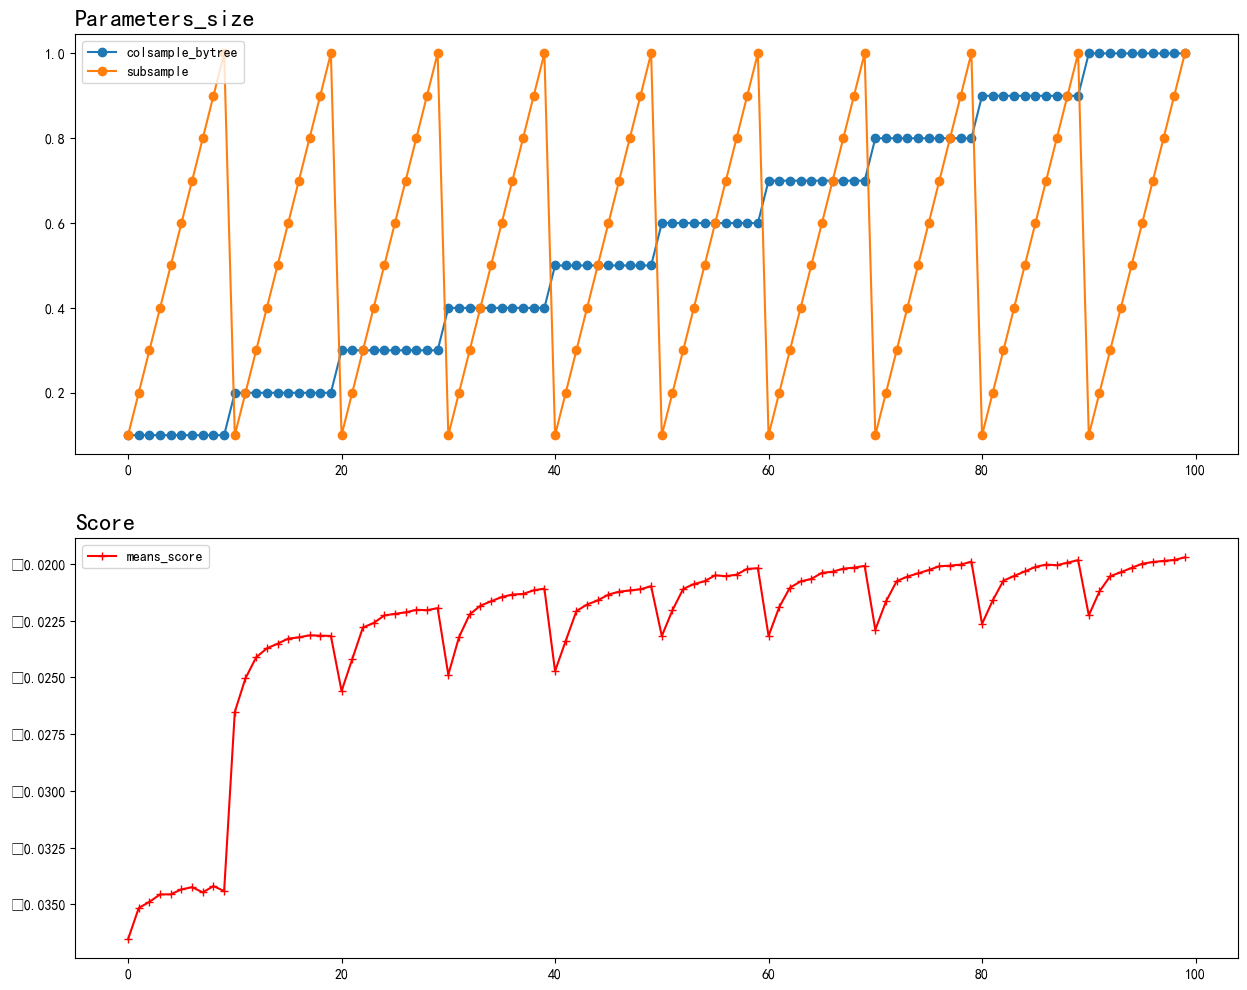

In [38]:
# s4 tuning subsample and colsample_bytree
params_dic_s4={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [60,70,80,90,100,110,120],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.00001,0.0001,0.001,0.01],
    'subsample': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1]
#    'lambda':[0.5,1,2,3,4,5],
#    'alpha':[0,1,2,3,4,5]    
}

adj_params = params_dic_s4
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100,
                'gamma':0}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 54 candidates, totalling 324 fits
[CV] END ............................alpha=0.01, lambda=0.05; total time=   2.9s
[CV] END ............................alpha=0.01, lambda=0.05; total time=   2.9s
[CV] END ............................alpha=0.01, lambda=0.05; total time=   2.8s
[CV] END ............................alpha=0.01, lambda=0.05; total time=   2.9s
[CV] END ............................alpha=0.01, lambda=0.05; total time=   2.9s
[CV] END ............................alpha=0.01, lambda=0.05; total time=   3.1s
[CV] END .............................alpha=0.01, lambda=0.1; total time=   3.0s
[CV] END .............................alpha=0.01, lambda=0.1; total time=   3.1s
[CV] END .............................alpha=0.01, lambda=0.1; total time=   3.0s
[CV] END .............................alpha=0.01, lambda=0.1; total time=   3.1s
[CV] END .............................alpha=0.01, lambda=0.1; total time=   3.0s
[CV] END .............................alpha=0.0

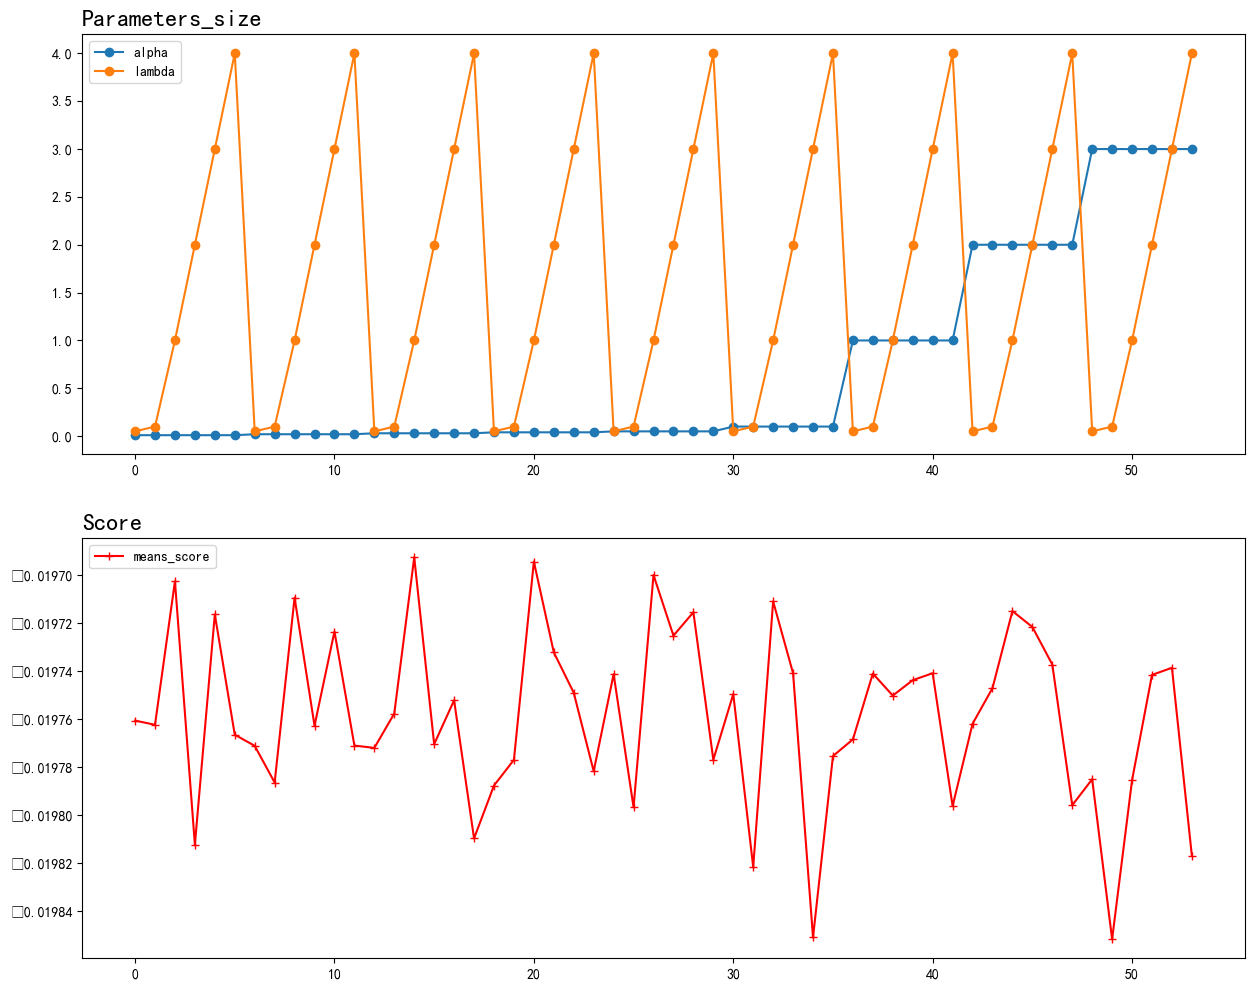

In [39]:
# s4 tuning lambda and alpha
params_dic_s5={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [60,70,80,90,100,110,120],
#    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.00001,0.0001,0.001,0.01],
#    'subsample': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1], 
#    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1]
     'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1, 2, 3], 
     'lambda': [0.05, 0.1, 1, 2, 3, 4]   
}

adj_params = params_dic_s5
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100,
                'gamma':0,'subsample':1,
                'colsample_bytree':1}
model_adjust_parameters(adj_params, fixed_params)

Fitting 6 folds for each of 9 candidates, totalling 54 fits
[CV] END ............................................eta=0.1; total time=   2.9s
[CV] END ............................................eta=0.1; total time=   2.9s
[CV] END ............................................eta=0.1; total time=   2.8s
[CV] END ............................................eta=0.1; total time=   2.9s
[CV] END ............................................eta=0.1; total time=   2.8s
[CV] END ............................................eta=0.1; total time=   2.9s
[CV] END ............................................eta=0.2; total time=   2.5s
[CV] END ............................................eta=0.2; total time=   2.5s
[CV] END ............................................eta=0.2; total time=   2.5s
[CV] END ............................................eta=0.2; total time=   2.5s
[CV] END ............................................eta=0.2; total time=   2.6s
[CV] END ........................................

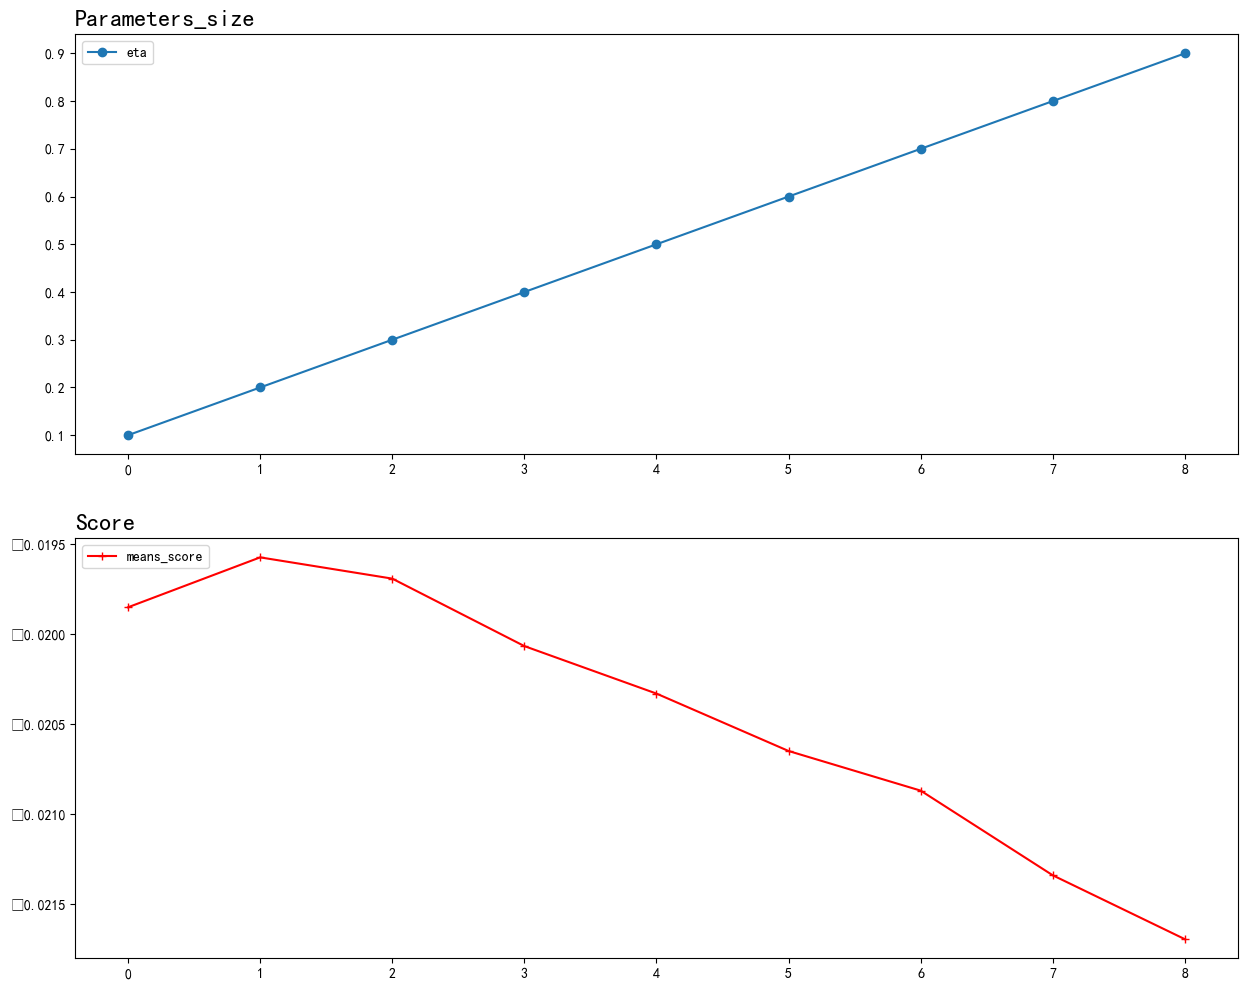

In [40]:
# s5 tuning eta
params_dic_s5={
#    'n_estimators':[10,20,30,50,80,130,210,340,550],
#    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
#    'min_child_weight': [60,70,80,90,100,110,120],
    'eta':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#    'gamma':[0,0.00001,0.0001,0.001,0.01],
#    'subsample': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1], 
#    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1]
#     'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1, 2, 3], 
#     'lambda': [0.05, 0.1, 1, 2, 3, 4]   
}

adj_params = params_dic_s5
fixed_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100,
                'gamma':0,'subsample':1,
                'colsample_bytree':1,
                'alpha': 0.03, 'lambda': 1}
model_adjust_parameters(adj_params, fixed_params)

In [ ]:
tuned_params = {'n_estimators':50,'tree_method':'gpu_hist',
                'max_depth':7, 'min_child_weight':100,
                'gamma':0,'subsample':1,
                'colsample_bytree':1,'eta':0.2,
                'alpha': 0.03, 'lambda': 1}

In [31]:
def metrics_sklearn(y_valid, y_pred_):
    """模型对验证集和测试集结果的评分"""
    # 准确率
    #accuracy = accuracy_score(y_valid, y_pred_)
    #print('Accuracy:%.2f%%' % (accuracy * 100))

    # error
    mean_squared_error_ = mean_squared_error(y_valid, y_pred_)
    print('mean_squared_error:%.2f' % mean_squared_error_)
    
    mean_absolute_error_ = mean_absolute_error(y_valid, y_pred_)
    print('mean_absolute_error:%.2f' % mean_absolute_error_)

    def mean_absolute_percentage_error(y_true, y_pred): 
        """Calculates MAPE given y_true and y_pred"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    percentage_error = mean_absolute_percentage_error(y_valid, y_pred_)
    print('percentage_error:%.2f%%' % percentage_error)
    '''
    # 召回率
    recall = recall_score(y_valid, y_pred_)
    print('Recall:%.2f%%' % (recall * 100))
    '''
    '''
    # F1值
    f1 = f1_score(y_valid, y_pred_)
    print('F1:%.2f%%' % (f1 * 100))'''
    '''
    # auc曲线下面积
    auc = roc_auc_score(y_valid, y_pred_)
    print('AUC:%.2f%%' % (auc * 100))

    # ks值
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_)
    ks = max(abs(fpr - tpr))
    print('KS:%.2f%%' % (ks * 100))'''

def feature_importance_selected(clf_model):
    """模型特征重要性提取与保存"""
    # 模型特征重要性打印和保存
    feature_importance = clf_model.get_booster().get_fscore()
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    feature_ipt = pd.DataFrame(feature_importance, columns=['特征名称', '重要性'])
    feature_ipt.to_csv('feature_importance.csv', index=False)
    print('特征重要性:', feature_importance)

    # 模型特征重要性绘图

    plot_importance(clf_model,max_num_features=30,height=0.6,grid=False)
    
    plt.show()

def model_fit():
    """模型训练"""
    # XGBoost训练过程，下面的参数是调试出来的最佳参数组合
    model = XGBRegressor(learning_rate=0.2, n_estimators=50, max_depth=7, min_child_weight=100,
                          subsample=1, colsample_bytree=1, gamma=0, reg_alpha=0.03, reg_lambda=1,tree_method='gpu_hist')
    model.fit(X_train, y_train)

    # 对验证集进行预测——类别
    y_pred = model.predict(X_test)
    y_test_ = y_test.values
    print('y_test:', y_test_[:20])
    print('y_pred:', y_pred[:20])

    # 模型对验证集预测结果评分
    metrics_sklearn(y_test_, y_pred)

    # 模型特征重要性提取、展示和保存
    feature_importance_selected(model)

    return model


y_test: [183.997 179.844 176.795 174.439 179.463 183.92  184.421 185.053 174.961
 174.784 174.57  174.778 175.223 180.639 184.495 179.483 175.696 175.65
 175.445 176.358]
y_pred: [185.9127  184.94681 178.43103 175.34538 174.14905 180.12155 185.32404
 184.89407 184.22418 172.88844 172.92679 173.0828  173.17079 173.17079
 180.31534 183.79605 179.11186 174.29706 174.87375 173.04588]
mean_squared_error:59.64
mean_absolute_error:5.45
percentage_error:1.96%
特征重要性: [('hour', 612.0), ('RealPower_-1q', 485.0), ('RealPower_-2q', 237.0), ('dayofyear', 166.0), ('dayofweek', 151.0), ('RealPower_-5q', 146.0), ('RealPower_-8q', 93.0), ('year', 92.0), ('RealPower_-24q', 91.0), ('RealPower_-4q', 83.0), ('RealPower_-3q', 75.0), ('RealPower_-7q', 61.0), ('RealPower_-6q', 56.0), ('RealPower_-12q', 53.0), ('RealPower_-15q', 50.0), ('RealPower_-14q', 46.0), ('RealPower_-9q', 44.0), ('RealPower_-11q', 43.0), ('RealPower_-21q', 42.0), ('RealPower_-13q', 41.0), ('RealPower_-18q', 39.0), ('RealPower_-20q', 38.0

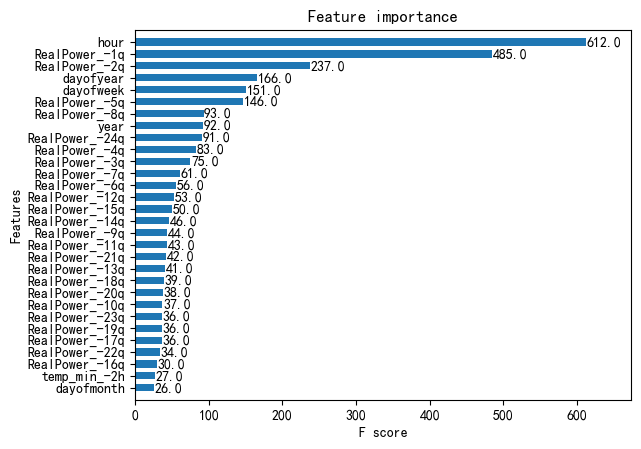

In [32]:
#fit data setting:
#train section: 2015-01-01 to 2019-01-01, K-fold cross-validation
#On building load

#tuned hyper parmas:
# learning_rate=0.2, n_estimators=50, max_depth=7, min_child_weight=100,
# subsample=1, colsample_bytree=1, gamma=0, reg_alpha=0.03, reg_lambda=1

best_model=model_fit()

In [14]:
def model_save_type(rg_model,save_path,prefix):
    # 模型训练完成后做持久化，模型保存为model模式，便于调用预测
    rg_model.save_model(save_path+prefix+'_XGBoost_Regression_model.model')

    # 模型保存为文本格式，便于分析、优化和提供可解释性
    rg = rg_model.get_booster()
    rg.dump_model(save_path+prefix+'_XGBoost_Regression_dump.txt')
model_save_type(best_model,'../model/XGBoost/','07-15_bld')


In [27]:
Y_pred=best_model.predict(X_test)
pd_y_test=pd.DataFrame(y_test)
pd_y_test['RealPower_pred']=Y_pred

In [29]:
pd_y_test.to_csv('../data/XGBoost_toy_case/bld_prediction_XGBoost_07-15.csv')